In [78]:
import numpy as np
from matplotlib.image import imread
import pywt
import matplotlib.pyplot as plt
import cv2
import itertools
import os
import pandas as pd
import time
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
plt.rcParams.update({'font.size': 12})

### Loading images from custom dataset

In [79]:
# Loading ALL images, really all
file_paths = []  
for root, dirs, files in os.walk("../../data/CUSTOM"):
    for file in files:
        if file != '.DS_Store':
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

In [80]:
test_image_path = '../../data/other/lenna.png'

def normalize_and_greyscale_imge(image):
    return np.mean(image*255,-1)

# We read the test image to compare with it
test_image = normalize_and_greyscale_imge(imread(test_image_path))

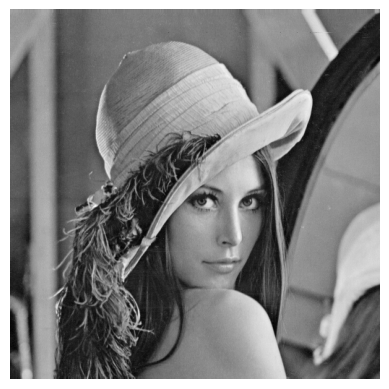

In [81]:
plt.imshow(test_image, cmap="grey")
plt.axis('off')
plt.show()

# Discrete Wavelet Transform

In this section we are going to check out how to сompress images using DWT. The main magic is hiding behind pywt.wavedec2 function that applies 2 dimentional wavelet decomposition to our image. This function applies $n+1$ low level and $n+1$ high level pass fiters where $n$ - is the level of decomposiotion. The more the level is the more is decomposition and, thus, compression.

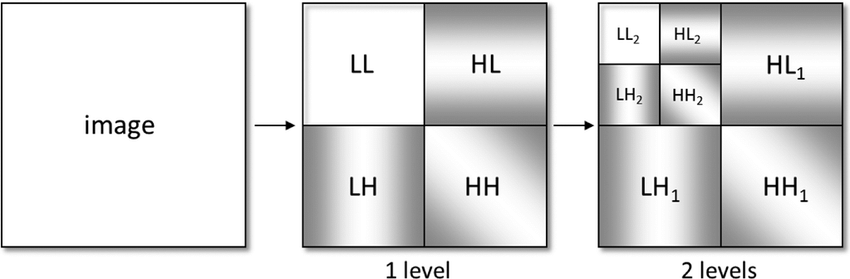

To compress image we will keep only LL block and thus can clearly see that compression factor for level 1 is 4, for level 2 is 16, for level 3 - 64 and so on

In [82]:
def compress_dwt(image_path, wavelet='haar', level=2):

    # firstly we transform image to grayscale to there would be 1 channel for all images to compare
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # taking the corefficient for choosen wavelet according to level of decomposition
    coeffs = pywt.wavedec2(img, wavelet, mode="antireflect",  level=level)  

    # to compress image we will throw away coefficients that contains high frequecy components, cruel world
    coeffs_thresh = []
    coeffs_thresh.append(coeffs[0])
    for detail_coeffs in coeffs[1:]: 
        h, v, d = detail_coeffs
        h_thresh = pywt.threshold(h, np.inf, mode='hard')
        v_thresh = pywt.threshold(v, np.inf, mode='hard')
        d_thresh = pywt.threshold(d, np.inf, mode='hard')
        coeffs_thresh.append((h_thresh, v_thresh, d_thresh))
    
    # reconstruction our image with only low frequency components
    reconstructed_img = pywt.waverec2(coeffs_thresh, wavelet)
    
    compression_factor = 4**level

    return reconstructed_img, compression_factor


In [83]:
maximum_level = 6
# using most common wavelets 
wavelets = ["haar" ,"sym2", "bior2.2", "db10", "coif5"]


psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

## Image compression example

/Users/yuriivoievidka/.pyenv/versions/3.11.3/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


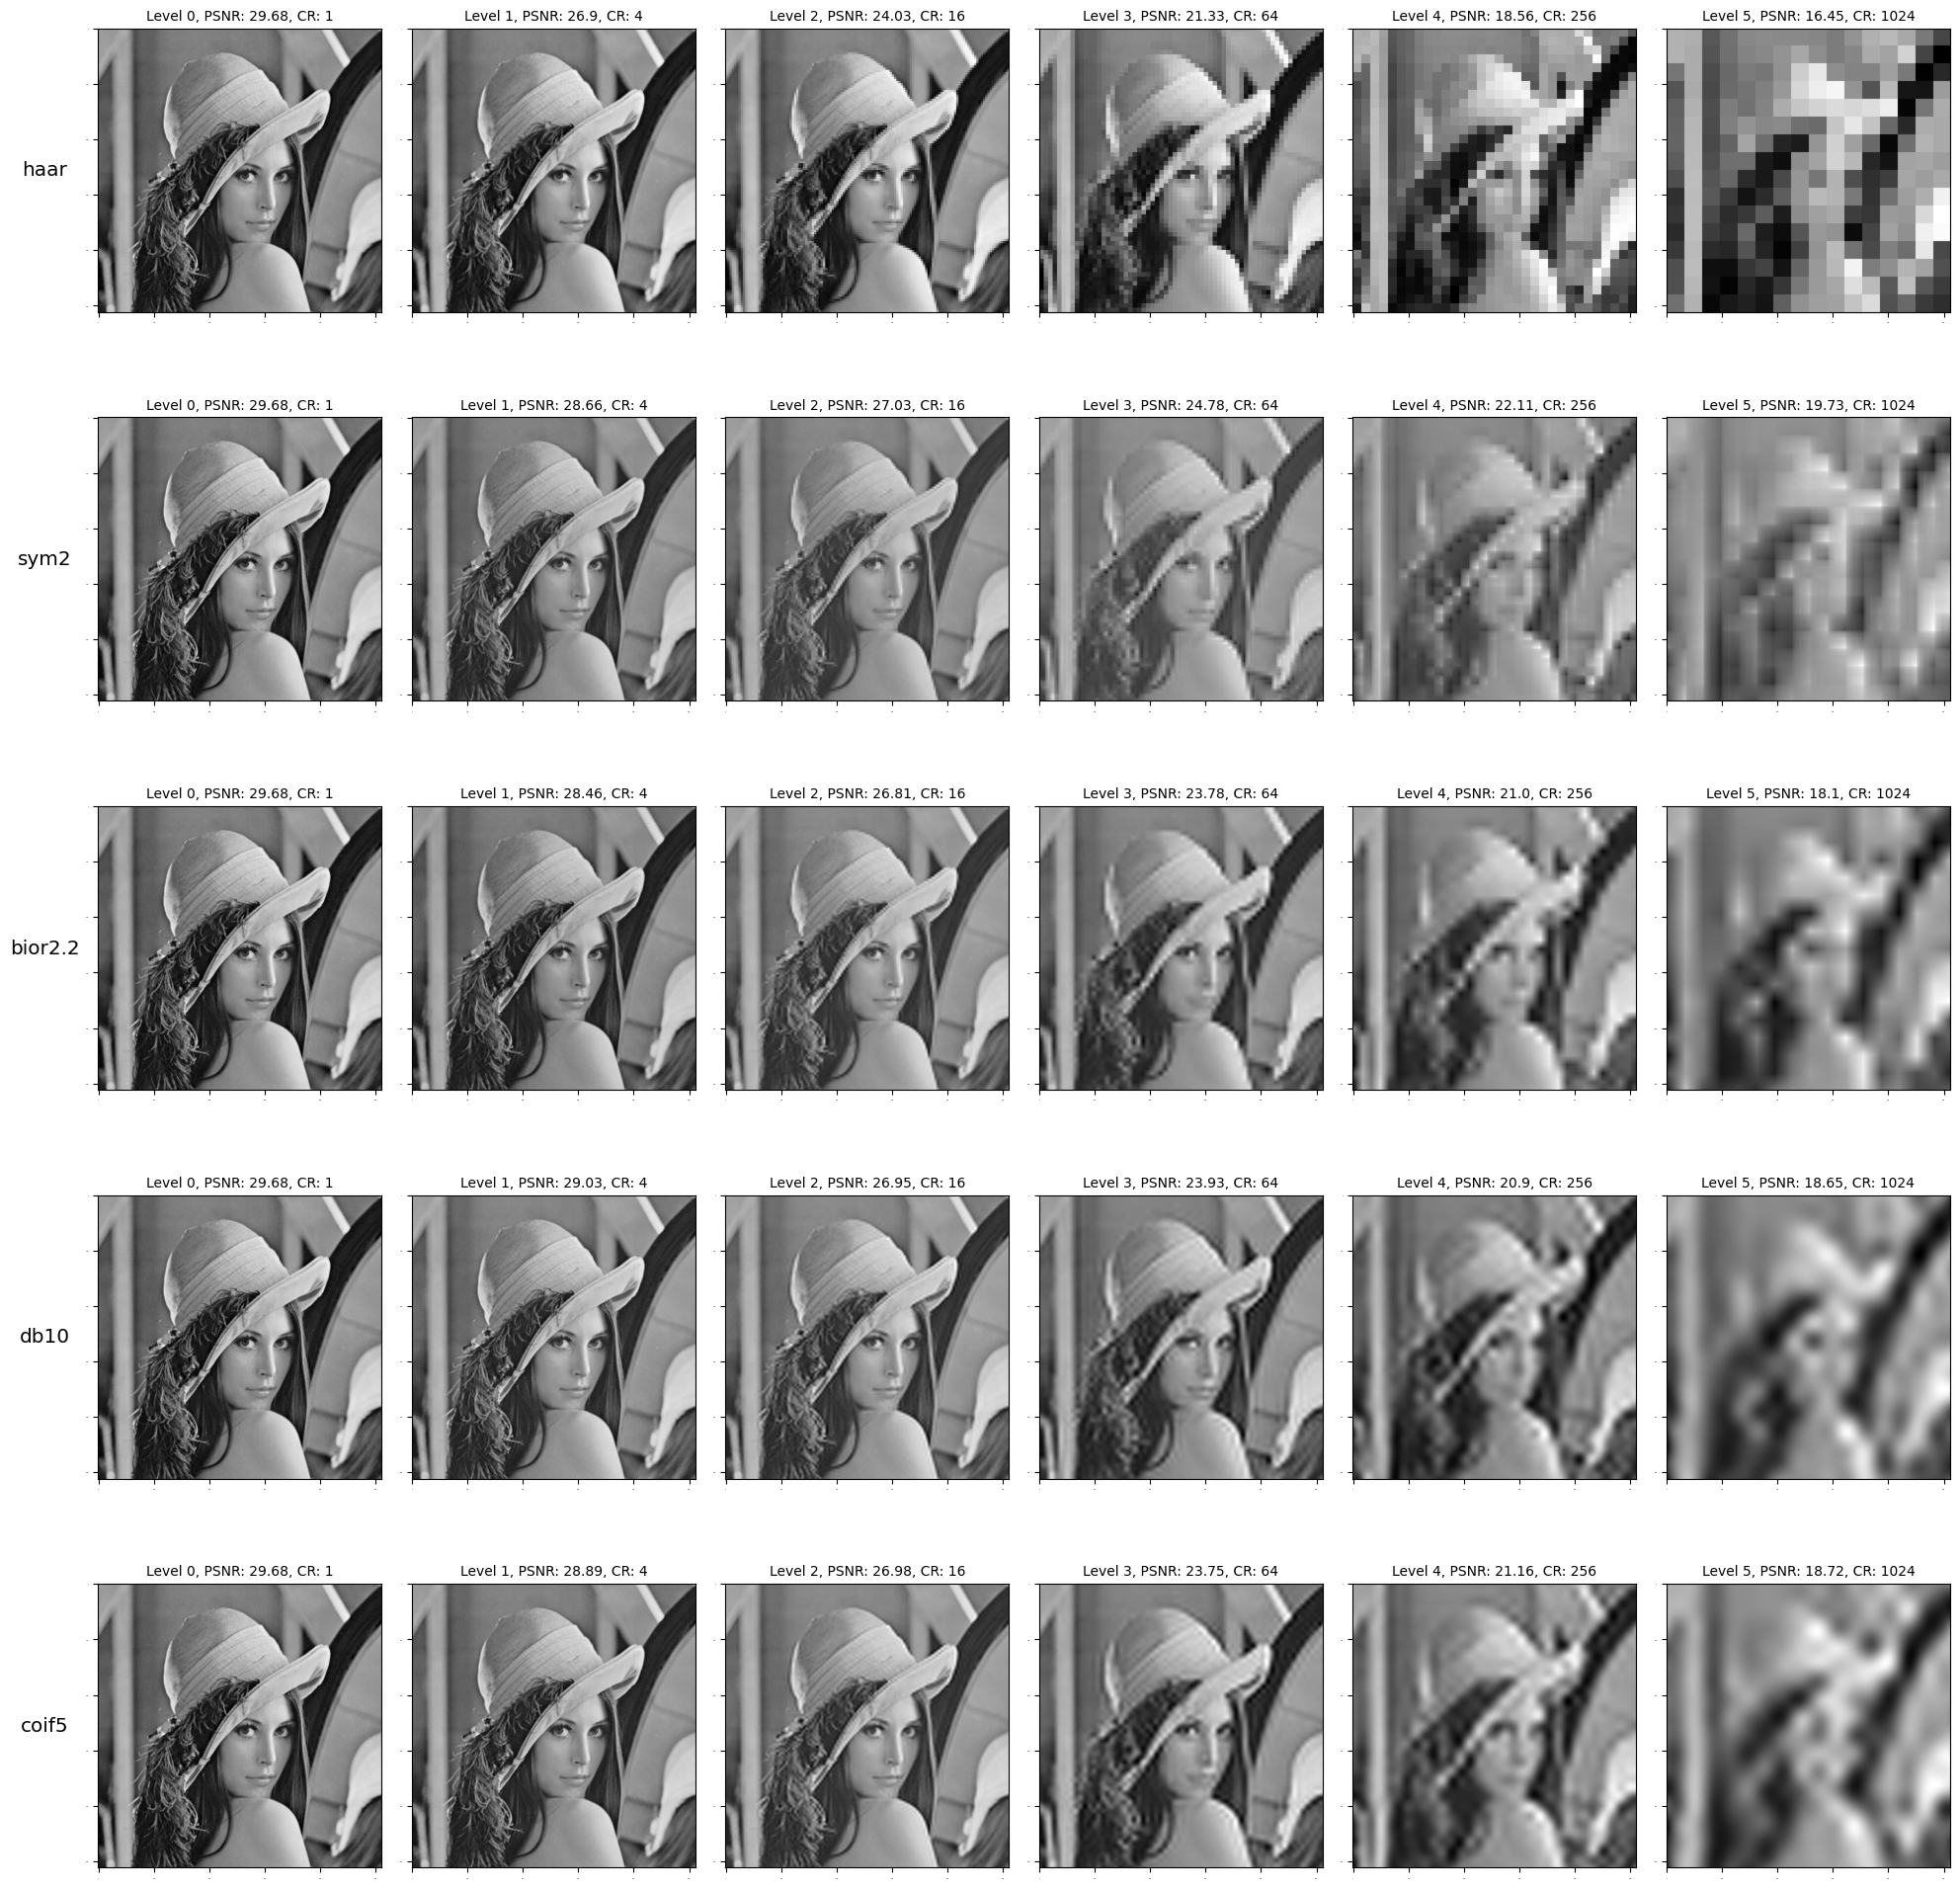

In [84]:
fig, axs = plt.subplots(len(wavelets), maximum_level, figsize=(20, 20))
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
test_iamge = np.mean(imread("../../data/other/lenna.png")*255,-1)
plt.ioff()
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=1)
    ax.tick_params(axis='both', which='minor', labelsize=1)  
    
for level in range(maximum_level):
    for wave_index, wave in enumerate(wavelets):
        reconstructed_image, compression_rate = compress_dwt(test_image_path, wavelet=wave, level=level)
        

        psnr_metric = psnr(test_iamge, reconstructed_image, data_range=test_iamge.max() - reconstructed_image.min())
        ssim_metric = ssim(test_iamge, reconstructed_image, data_range=test_iamge.max() - reconstructed_image.min())
        axs[wave_index, level].imshow(reconstructed_image, cmap='gray')
        axs[wave_index, level].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)

        if level == 0:  
            axs[wave_index, level].set_ylabel(wave, rotation=0, size='large', labelpad=30, verticalalignment='center')

        psnr_values[wave].append(psnr_metric)
        compressions[wave].append(compression_rate)
        ssims[wave].append(ssim_metric)

plt.tight_layout()
plt.show()

## Gathering data by testing on all datasets

#### Resetting variables

In [85]:
psnr_values = {wavelet: [] for wavelet in wavelets}
compressions = {wavelet: [] for wavelet in wavelets}
ssims = {wavelet: [] for wavelet in wavelets}
times = {wavelet: [] for wavelet in wavelets}

In [86]:
for level in range(maximum_level):
    local_psnr_values = []
    local_compressions = []
    local_ssims = []
    local_times = []
    for wave_index, wave in enumerate(wavelets):
        for image_path in file_paths:
            base_image =  np.mean(imread(image_path)*255, -1)
            start_time = time.perf_counter()
            reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wave, level=level)
            end_time = time.perf_counter()
            if reconstructed_image.shape[0] == base_image.shape[0] and reconstructed_image.shape[1] == base_image.shape[1]:
                psnr_metric = psnr(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())
                ssim_metric = ssim(base_image, reconstructed_image, data_range=base_image.max() - reconstructed_image.min())

            local_times.append(end_time - start_time)
            local_psnr_values.append(psnr_metric)
            local_compressions.append(compression_rate)
            local_ssims.append(ssim_metric)
        
        times[wave].append(np.mean(local_times))
        psnr_values[wave].append(np.mean(local_psnr_values))
        compressions[wave].append(np.mean(local_compressions))
        ssims[wave].append(np.mean(local_ssims))

/Users/yuriivoievidka/.pyenv/versions/3.11.3/envs/data-analysis/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/Users/yuriivoievidka/.pyenv/versions/3.11.3/envs/data-analysis/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


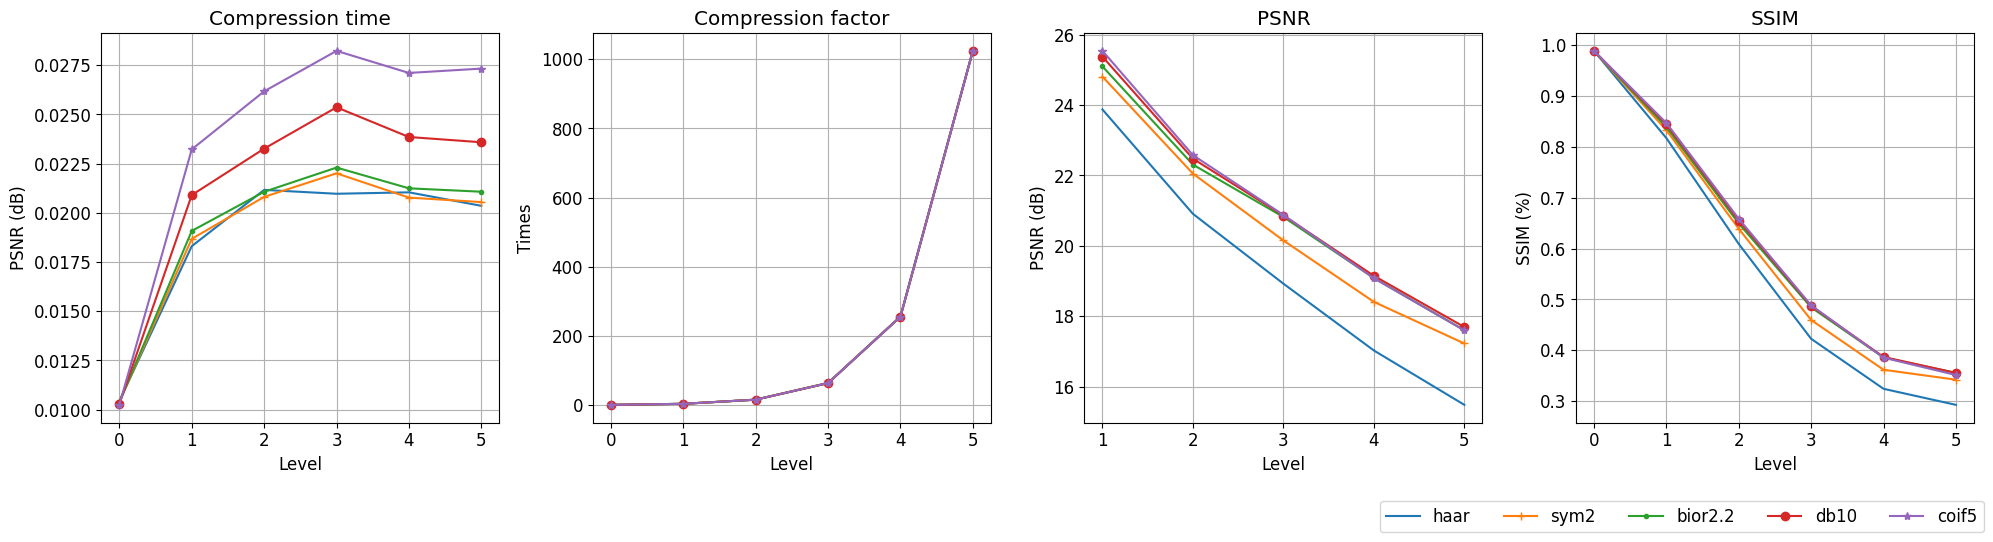

In [87]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
marker = itertools.cycle((',', '+', '.', 'o', '*')) 


# Compression time
for wavelet in wavelets:
    axs[0].plot(np.arange(0, maximum_level), times[wavelet],label=wavelet, marker=next(marker))
    axs[0].set_title('Compression time')
    axs[0].grid('on')
    axs[0].set_xlabel('Level')
    axs[0].set_ylabel('PSNR (dB)')

# Compression factor
for wavelet in wavelets:
    axs[1].plot(np.arange(0, maximum_level),  compressions[wavelet],label=wavelet, marker=next(marker))
    axs[1].set_title('Compression factor')
    axs[1].grid('on')
    axs[1].set_xlabel('Level')
    axs[1].set_ylabel('Times')

# PSNR
for wavelet in wavelets:
    axs[2].plot(np.arange(0, maximum_level), psnr_values[wavelet], label=wavelet, marker=next(marker))
    axs[2].set_title('PSNR')
    axs[2].grid('on')
    axs[2].set_xlabel('Level')
    axs[2].set_ylabel('PSNR (dB)')

# SSIM
for wavelet in wavelets:
    axs[3].plot(np.arange(0, maximum_level),  ssims[wavelet], label=wavelet, marker=next(marker))
    axs[3].set_title('SSIM')
    axs[3].grid('on')
    axs[3].set_xlabel('Level')
    axs[3].set_ylabel('SSIM (%)')
    handles, labels = axs[3].get_legend_handles_labels()


fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, -0.001), ncol=len(wavelets))
plt.tight_layout()
plt.show()

## Comparing More Precise 

Let's take a closer look two example of comprassion with Haar and Sym20 to check visually how images are compressed

In [88]:
def display_wavelet_example(image_path, wavelet):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    marker = itertools.cycle((',', '+', '.', 'o', '*')) 

    level=0
    reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wavelet, level=level)
    axs[0].imshow(reconstructed_image, cmap='gray')
    axs[0].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)
    axs[0].axis('off')



    level=1
    reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wavelet, level=level)
    axs[1].imshow(reconstructed_image, cmap='gray')
    axs[1].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)
    axs[1].axis('off')


    level=3
    reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wavelet, level=level)
    axs[2].imshow(reconstructed_image, cmap='gray')
    axs[2].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)
    axs[2].axis('off')


    level=4
    reconstructed_image, compression_rate = compress_dwt(image_path, wavelet=wavelet, level=level)
    axs[3].imshow(reconstructed_image, cmap='gray')
    axs[3].set_title(f'Level {level}, PSNR: {np.round(psnr_metric, 2)}, CR: {compression_rate}', fontsize=10)
    axs[3].axis('off')


    plt.tight_layout()
    plt.show()

### Haar

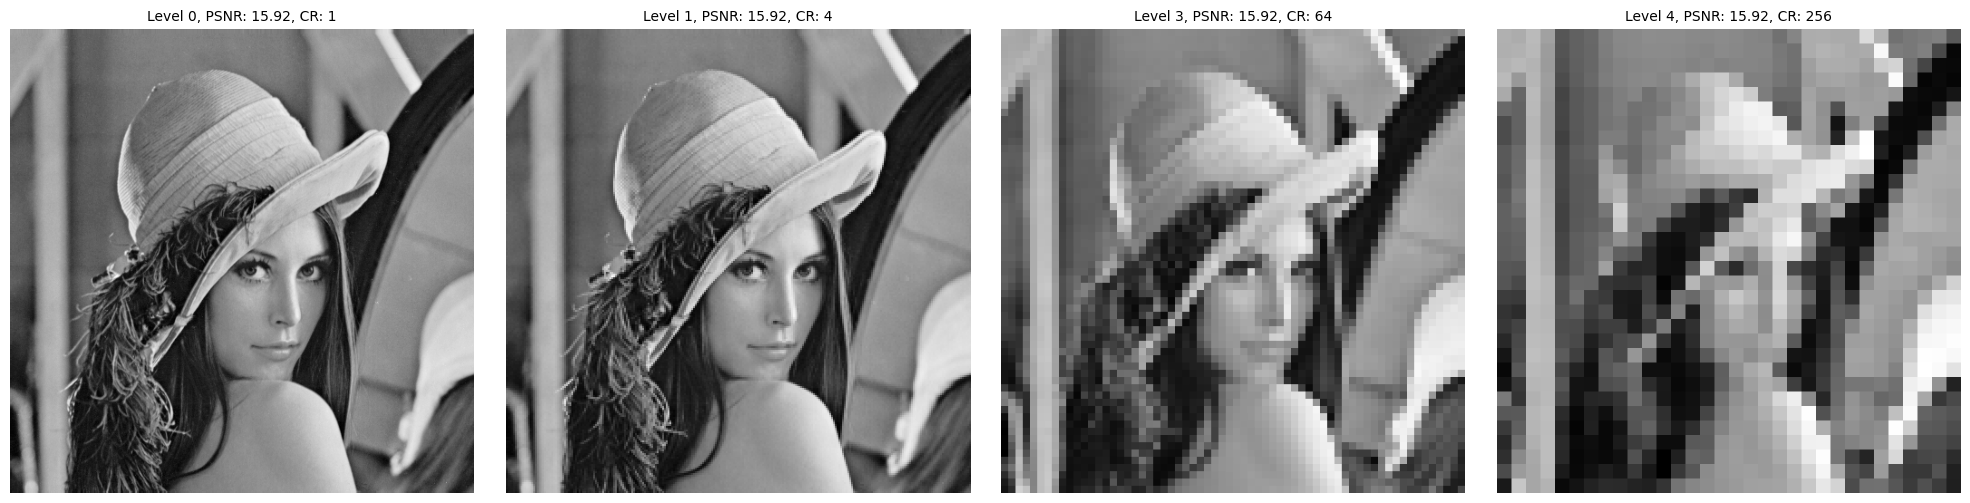

In [89]:
display_wavelet_example(test_image_path, 'haar')

### Sym20

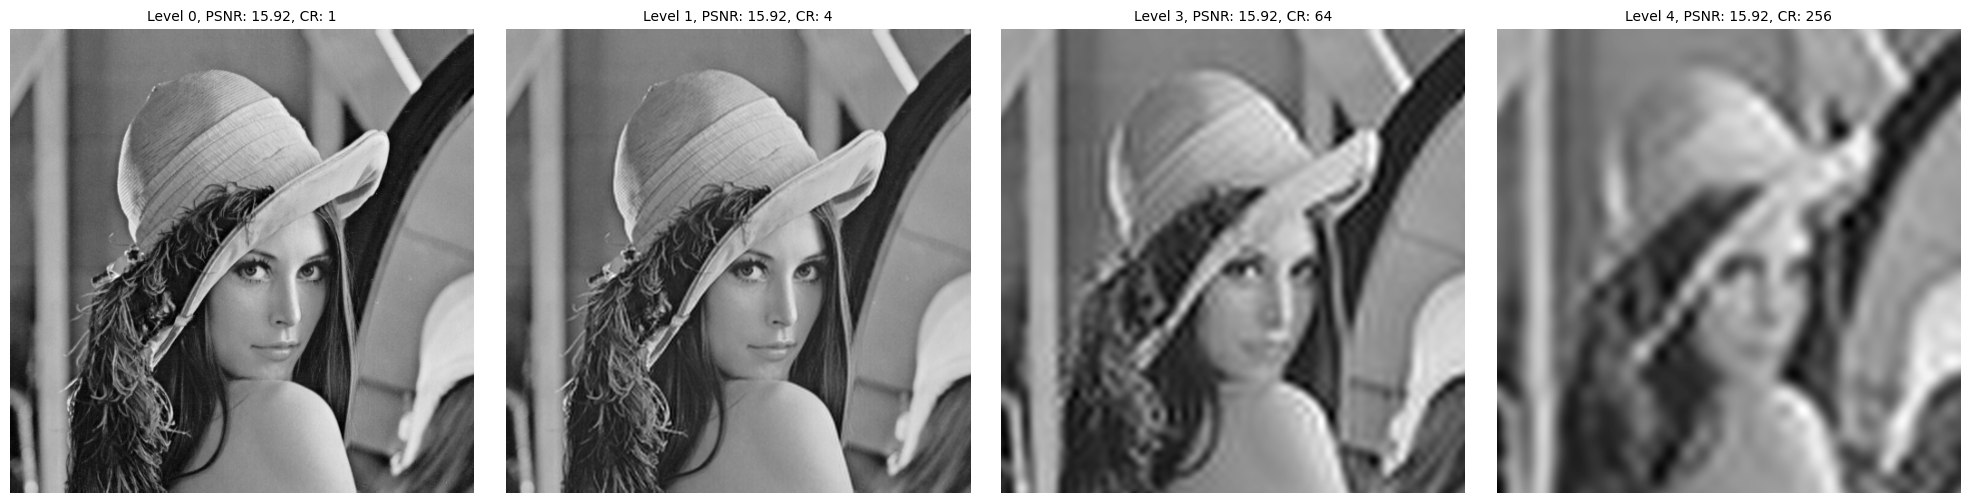

In [90]:
display_wavelet_example(test_image_path, 'sym20')

### Results

We can see that Haar wavelet compresse the images quicker than any other wavelet but it has the biggest image corruption according to SSIM plot. We also see that Daubechies10 wavelet preserves the most of image quality and comresses the image faster compared to Coilfel5. That is one of the reasons why Daubechies wavelet family is used in practice to compress the images